In [1]:
# To read the .csv files
import pandas as pd 
# To store the direct inheritance relations as a graph
import networkx as nx

In [32]:
import os
try:
    os.mkdir("graphs")
except FileExistsError:
    pass

In [2]:
from code_to_langs import wiki_code_to_lang

# Tree generation notebook

This notebook provides the scripts used to generate the trees described in part 7.1 Phylogeny Reconstruction. 

You need networkx and pandas.
To draw the graphs, you need to have graphviz installed on your machine.

## Utils

# Data extraction
This step is quite slow: building the relation trees can take up to half an hour.

In [3]:
path_values = "../data/split_etymdb/etymdb_values.csv"
path_link = "../data/split_etymdb/etymdb_links_info.csv"

df_values = pd.read_csv(path_values,
                        sep='\t',
                        names=["id", "lang", "field", "lexeme", "meaning"],
                        dtype={"id": int, "lang": str, "field": int, "meaning": str}).set_index("id")

df_link = pd.read_csv(path_link,
                      sep='\t',
                      names=["relation_type", "child", "parent"],
                      dtype={"relation_type": str, "child": int, "parent": int})

df_inher = df_link.loc[df_link['relation_type'].isin(["inh"])]
df_bor = df_link.loc[df_link['relation_type'].isin(["bor"])]
df_cog = df_link.loc[df_link['relation_type'].isin(["cog"])]

In [4]:
def get_graph(df: pd.DataFrame, df_values: pd.DataFrame, oriented: bool = True):
    """ Builds a graph for the links between the different database lexemes. 
    
    df: inheritance/borrowing/cognacy links dataframe
    df_values: dataframe containing all the lexemes with their ids
    oritented: True if inheritance, False otherwise
    """
    tree = nx.DiGraph() if oriented else nx.Graph()

    for index, row in df.iterrows():
        child_ix = row["child"]
        parent_ix = row["parent"]
        if child_ix >= 0 and parent_ix >= 0: # We ignore compositional relationships in this demo 
            for node_ix in [child_ix, parent_ix]:
                node_name = str(df_values.loc[node_ix].lexeme) + "_" + str(df_values.loc[node_ix].lang)
                tree.add_node(node_name, 
                              lang=str(df_values.loc[node_ix].lang), 
                              lexeme= str(df_values.loc[node_ix].lexeme),
                              meaning= str(df_values.loc[node_ix].meaning),
                              id= int(node_ix))
            tree.add_edge(str(df_values.loc[parent_ix].lexeme) + "_" + str(df_values.loc[parent_ix].lang), 
                          str(df_values.loc[child_ix].lexeme) + "_" + str(df_values.loc[child_ix].lang))
    
    return tree

In [5]:
inher_graph = get_graph(df_inher, df_values) 

In [7]:
print(f"This database contains {inher_graph.number_of_nodes()} words" \
      f"linked by {inher_graph.number_of_edges()} inheritance relations")

This database contains 418329 wordslinked by 320524 inheritance relations


In [19]:
cog_graph = get_graph(df_cog, df_values, False)

In [20]:
print(f"This database contains {cog_graph.number_of_nodes()} words" \
      f"linked by {cog_graph.number_of_edges()} cognacy relations")

This database contains 155084 wordslinked by 144072 cognacy relations


In [10]:
bor_graph = get_graph(df_bor, df_values) 

In [11]:
print(f"This database contains {bor_graph.number_of_nodes()} words" \
      f"linked by {bor_graph.number_of_edges()} borrowing relations")

This database contains 153340 wordslinked by 95920 borrowing relations


# Tree generation

## Utils

In [12]:
def add_val_to_ctr_dict(cur_dict, key):
    try:
        cur_dict[key] += 1
    except KeyError:
        cur_dict[key] = 1

### Graph save

In [13]:
def save_graph(graph, min_weight="", predecessor="", pc = "", name=""):
    """ Saving the graph representation to file """
    graph_name = ("pred_" if predecessor else "succ_") + str(min_weight) + "_" + str(pc) + name 
    gviz_rep = nx.nx_agraph.to_agraph(graph)
    gviz_rep.layout(prog='dot', args='-Grankdir=LR -Granksep=2')
    gviz_rep.write("graphs/graph_" + graph_name + ".dot")
    gviz_rep.draw("graphs/graph_" + graph_name + ".dot", format="png")

In [41]:
def draw_graph(graph):
    """Draws the graph in the notebook. 
    
    We recommend using this function only for reduced graphs, as it will slow down your notebook considerably otherwise"""
    %matplotlib notebook
    nx.draw_networkx(graph) 

### Extract lang info

To simplify

In [26]:
def get_cognate_languages_graph(input_tree):
    """Get the weighted language tree for all languages, for a type of relation in a direction 
    
    Each time two nodes of the tree are implicated 
    """
    result_tree = nx.Graph()
    ctr = 0
    for node_ix in input_tree.nodes:
        lang = input_tree.nodes[node_ix]["lang"]
        if not result_tree.has_node(lang):
            result_tree.add_node(lang)
            
        cognate_langs = [input_tree.nodes[n_ix]["lang"] for n_ix in input_tree.neighbors(node_ix)]
        for cog_lang in cognate_langs:
            if not result_tree.has_node(cog_lang):
                result_tree.add_node(cog_lang)
            if result_tree.get_edge_data(lang, cog_lang, default="ERROR") == "ERROR":
                result_tree.add_edge(lang, cog_lang, weight = 0)
            result_tree[lang][cog_lang]["weight"] += 1
    return result_tree

In [27]:
def get_directed_languages_tree(input_tree, predecessors = True):
    """Get the weighted language tree for all languages, for a type of directed relation (inh or bor) in a direction 
    
    Each time two nodes of the tree are implicated 
    """
    result_tree = nx.DiGraph()
    ctr = 0
    for node_ix in input_tree.nodes:
        lang = input_tree.nodes[node_ix]["lang"]
        if not result_tree.has_node(lang):
            result_tree.add_node(lang)
        
        if predecessors:
            predecessors_langs = [input_tree.nodes[succ_ix]["lang"] for succ_ix in input_tree.predecessors(node_ix)]
        else:
            predecessors_langs = [input_tree.nodes[succ_ix]["lang"] for succ_ix in input_tree.successors(node_ix)]
            
        for pred_lang in predecessors_langs:
            if not result_tree.has_node(pred_lang):
                result_tree.add_node(pred_lang)
            if result_tree.get_edge_data(lang, pred_lang, default="ERROR") == "ERROR":
                result_tree.add_edge(lang, pred_lang, weight = 0)
            result_tree[lang][pred_lang]["weight"] += 1
            
    return result_tree

In [28]:
def total_language_tree(inher_tree, bor_tree, cog_tree):
    """Makes a fusion between the three trees, to carry all info on the same edges"""
    def get_value(dct, in_lang, out_lang, name):
        try:
            res = dct[in_lang][out_lang][name]
        except KeyError:
            res = 0
        return res
    # Get oriented trees
    lang_inher_tree = get_directed_languages_tree(inher_tree, predecessors=True)
    lang_bor_tree = get_directed_languages_tree(bor_tree, predecessors=True)
    lang_cog_tree = get_cognate_languages_graph(cog_tree)
    
    result_tree = nx.DiGraph()
    
    # Gathering information from previous graphs
    result_tree.add_nodes_from(lang_inher_tree.nodes)
    result_tree.add_nodes_from(lang_bor_tree.nodes)
    result_tree.add_nodes_from(lang_cog_tree.nodes)
    
    result_tree.add_edges_from(lang_inher_tree.edges, total=0, inh=0, cog=0, bor=0, score=1)
    result_tree.add_edges_from(lang_bor_tree.edges, total=0, inh=0, cog=0, bor=0, score=1)
    result_tree.add_edges_from(lang_cog_tree.edges, total=0, inh=0, cog=0, bor=0, score=1)
    result_tree.add_edges_from([(edge[1], edge[0]) for edge in lang_cog_tree.edges], total=0, inh=0, cog=0, bor=0, score=1)
    
    name_to_tree = {"inh": lang_inher_tree, "bor": lang_bor_tree, "cog": lang_cog_tree}
    for rel_name, tree in name_to_tree.items():
        for l_in, l_out in tree.edges():
            result_tree[l_in][l_out].update({rel_name: tree[l_in][l_out]["weight"]})
            if rel_name == "cog":  # cognacy is bidir
                result_tree.add_edge(l_out, l_in)
                result_tree[l_out][l_in].update({rel_name: tree[l_out][l_in]["weight"]})
                result_tree[l_out][l_in]["total"] += tree[l_out][l_in]["weight"]
            result_tree[l_in][l_out]["total"] += tree[l_in][l_out]["weight"]
        
    for l_in, l_out in result_tree.edges():
        for name in name_to_tree.keys():
            result_tree[l_in][l_out]["p" + name] = float("{0:.2f}".format(
                100 * get_value(result_tree, l_in, l_out, name) / result_tree[l_in][l_out]["total"]
            ))

    result_tree = nx.relabel_nodes(result_tree, wiki_code_to_lang)
    return result_tree

In [29]:
all_info_tree = total_language_tree(inher_graph, bor_graph, cog_graph)

## 7.1.1 Naive algorithm

In [33]:
def get_very_simple_language_tree(total_tree, min_num_items: int):
    # Extract most likely node
    subgraph_edges = []
    for degree in sorted(set([d for n, d in total_tree.in_degree()])):
        for cur_lang in [n for n, d in total_tree.in_degree() if d == degree]:
            try:
                max_edges = sorted(total_tree.edges(cur_lang, data=True), 
                                  key=lambda x: (-x[2]["total"], x[2]["pbor"], x[2]["pcog"]) 
                                      if x[2]["pbor"] < 25 and x[2]["pcog"] < 25 
                                      else (0, 0, 0))[0]
                for max_edge in [max_edges]:
                    if max_edge[2]["inh"] > min_num_items:
                        subgraph_edges.append((cur_lang, max_edge[1]))
            except IndexError:
                pass
    
    # family links
    high_score_subgraph = total_tree.edge_subgraph(subgraph_edges)
    
    return high_score_subgraph

In [34]:
very_simple_tree = get_very_simple_language_tree(all_info_tree, 4)
save_graph(very_simple_tree, 4, True, name="very_simple_pm") 

## 7.1.2 : Refined algorithm

In [35]:
def get_simple_language_tree(total_tree, min_num_items: int):
    # Extract most likely node
    subgraph_edges = []
    for degree in sorted(set([d for n, d in total_tree.in_degree()])):
        for cur_lang in [n for n, d in total_tree.in_degree() if d == degree]:
            try:
                max_edges = sorted(total_tree.edges(cur_lang, data=True), 
                                  key=lambda x: (-x[2]["total"], x[2]["pbor"], x[2]["pcog"]) 
                                      if x[2]["pbor"] < 25 and x[2]["pcog"] < 25 
                                      else (0, 0, 0))[:5] 
                for max_edge in max_edges: 
                    if max_edge[2]["inh"] > min_num_items:
                        subgraph_edges.append((cur_lang, max_edge[1]))
            except IndexError:
                pass
    
    # family links
    high_score_subgraph = total_tree.edge_subgraph(subgraph_edges)
    # for very simple: return high_score_subgraph

    edge_list = []
    for degree in sorted(set([d for n, d in high_score_subgraph.in_degree()])):
        for cur_lang in [n for n, d in high_score_subgraph.in_degree() if d == degree]:
            lv1_parents = list(high_score_subgraph.successors(cur_lang))
            if cur_lang in lv1_parents: # autoremove
                lv1_parents.remove(cur_lang)

            # Parent simplification
            for lv1_parent in high_score_subgraph.successors(cur_lang):
                if lv1_parent in lv1_parents:
                    for lv2_parent in high_score_subgraph.successors(lv1_parent):
                        if high_score_subgraph[lv1_parent][lv2_parent]["inh"] >= 20:
                            try:
                                lv1_parents.remove(lv2_parent)
                                high_score_subgraph[cur_lang][lv1_parent]["score"] += high_score_subgraph[cur_lang][lv2_parent]["score"] #+ high_score_subgraph[cur_lang][lv2_parent]["inh"]
                                high_score_subgraph[lv1_parent][lv2_parent]["score"] += high_score_subgraph[cur_lang][lv2_parent]["score"]# + high_score_subgraph[cur_lang][lv2_parent]["inh"]
                            except ValueError:
                                pass
            if lv1_parents:
                max_edge = sorted({lv1_parent: total_tree[cur_lang][lv1_parent] for lv1_parent in lv1_parents}.items(), 
                                   key = lambda x: (-2 * x[1]["score"] - x[1]["inh"] + 20 * x[1]["bor"] + 5 * x[1]["cog"], -x[1]["score"], -x[1]["inh"]))[0]
                edge_list.append((cur_lang, max_edge[0]))    
    
    return total_tree.edge_subgraph(edge_list)

In [68]:
all_info_tree = total_language_tree(inher_graph, bor_graph, cog_graph)

min_num_items = 5 
complex_subgraph = get_simple_language_tree(all_info_tree, min_num_items)

# This detects potential problems - Some cycles are to be expected
print("Is acyclic:", nx.is_directed_acyclic_graph(complex_subgraph))
if not nx.is_directed_acyclic_graph(complex_subgraph):
    print("Cycles", nx.find_cycle(complex_subgraph))

Is acyclic: False
Cycles [('Proto-Albanian', 'Albanian'), ('Albanian', 'Proto-Albanian')]


In [69]:
save_graph(complex_subgraph, min_num_items, True, name="complex_graph") 

<IPython.core.display.Javascript object>


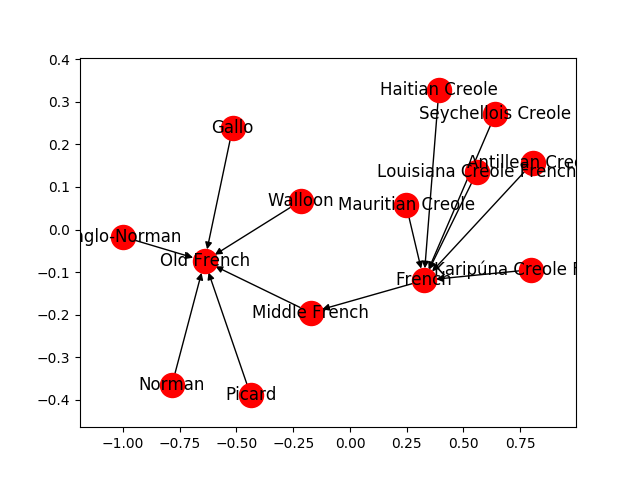

In [70]:
# We want to draw all children of a specific language
lang = "Old French"
# Careful with the graph direction: an arrow is from child to parent - was easier to iterate through the graph
children_set = nx.ancestors(complex_subgraph, lang) # to get all parents use descendants
children_set.add(lang)
child_subgraph = complex_subgraph.subgraph(children_set)
draw_graph(child_subgraph)

In [76]:
# Get more info about a relation
child_subgraph.get_edge_data('Middle French', 'Old French')

{'total': 1537,
 'inh': 1532,
 'cog': 4,
 'bor': 1,
 'score': 7,
 'pinh': 99.67,
 'pbor': 0.07,
 'pcog': 0.26}

In [72]:
# To get the list of edges (they are oriented)
child_subgraph.edges

OutEdgeView([('Norman', 'Old French'), ('Haitian Creole', 'French'), ('Picard', 'Old French'), ('Antillean Creole', 'French'), ('Anglo-Norman', 'Old French'), ('Louisiana Creole French', 'French'), ('Gallo', 'Old French'), ('Walloon', 'Old French'), ('French', 'Middle French'), ('Karipúna Creole French', 'French'), ('Middle French', 'Old French'), ('Mauritian Creole', 'French'), ('Seychellois Creole', 'French')])